## 1. Biblioteki

In [3]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import os
import talos as ta
from talos.model.early_stopper import early_stopper
from sklearn.preprocessing import StandardScaler

%load_ext tensorboard
import tensorflow_addons as tfa
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.metrics import Recall, Precision
import seaborn as sns

from sklearn.model_selection import train_test_split


import tensorflow as tf

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard



## 2. Dane

In [2]:
train_df=pd.read_csv("D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/Dane_do_uczenia_M.csv", encoding="utf-8")
del train_df['Unnamed: 0']

In [3]:
train_df.head()

,ENSG00000212232.1,ENSG00000238741.1,ENSG00000252481.1,ENSG00000239002.3,ENSG00000212443.1,ENSG00000274012.1,ENSG00000252010.1,ENSG00000202198.1,ENSG00000251791.1,ENSG00000202058.1,...,ENSG00000241475.1,ENSG00000274618.1,ENSG00000227293.1,ENSG00000253526.1,ENSG00000270654.1,ENSG00000271394.1,ENSG00000265423.1,ENSG00000253165.1,ENSG00000201901.1,scale
0,27.356617,31.768974,27.356617,5.294829,8.824715,6.645010e+02,2.647415,4.235863e+02,7.059772,16.766959,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,M0
1,8.695633,1.086954,6.521724,2.173908,0.000000,1.758692e+03,1.086954,5.434770e+01,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,M0
2,20.185177,77.002713,7.475992,4.485595,8.971190,2.775836e+03,2.242797,2.609121e+02,6.728392,10.466388,...,0.000000,0.747599,0.0,0.747599,0.0,0.747599,0.000000,0.0,0.000000,M0
3,18.157930,17.431612,6.536855,2.178952,2.905269,2.338741e+02,3.631586,6.827382e+01,1.452634,1.452634,...,0.726317,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,M0
4,29912.168049,21631.677176,9554.333460,20332.131551,5136.495208,1.255850e+06,19221.760289,1.926818e+06,5198.182500,2655.637935,...,0.000000,953.068666,0.0,20.562431,0.0,269.367843,64.771657,0.0,123.374585,M0


In [4]:
train_df['scale'].loc[(train_df['scale'] == 'M0')] = 0
train_df['scale'].loc[(train_df['scale'] == 'M1')] = 1

In [5]:
train_df=train_df.loc[(train_df['scale']!='MX')]

In [6]:
caly_df=train_df.copy()

In [7]:
caly_label=caly_df['scale']
del caly_df['scale']

In [8]:
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42,stratify=train_df['scale'])
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42,stratify=test_df['scale'])


train_label=train_df['scale']
test_label=test_df['scale']
val_label=val_df['scale']
del train_df['scale']
del test_df['scale']
del val_df['scale']


In [9]:
len(list(train_df))

110

In [10]:
train_label.shape

(568,)

## 1.2 Standaryzacja

In [14]:
scaler = StandardScaler()
train_df=scaler.fit_transform(train_df)
test_df=scaler.fit_transform(test_df)
val_df=scaler.fit_transform(val_df)
caly_df=scaler.fit_transform(caly_df)

In [15]:
train_df

array([[-0.23532639, -0.28536286, -0.29189695, ..., -0.20273415,
        -0.13658188, -0.25716709],
       [-0.23488914, -0.28412701, -0.28766847, ..., -0.20273415,
        -0.13658188, -0.25716709],
       [-0.23513615, -0.28194648, -0.28119849, ..., -0.1127296 ,
        -0.13658188, -0.18291094],
       ...,
       [-0.23560858, -0.28411483, -0.29158105, ..., -0.20273415,
        -0.07110588, -0.25716709],
       [13.92769305,  3.11477926,  6.81130447, ..., -0.05473062,
        -0.13658188,  1.2895196 ],
       [-0.23495945, -0.28021459, -0.28164044, ..., -0.20273415,
        -0.07405669, -0.25716709]])

In [16]:
train_label=np.asarray(train_label).astype(np.int)
test_label=np.asarray(test_label).astype(np.int)
val_label=np.asarray(val_label).astype(np.int)

In [17]:
valy_label=np.asarray(caly_label).astype(np.int)

In [18]:
train_label

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
train_label.shape

(568,)

In [20]:
test_label.shape

(71,)

## 2.1 Słownik parametrów do wypróbowania

In [27]:
p = {
    'first_neuron':55,  #Done
     'hidden_neuron':50, #Done

     'hidden_layers':0,   

     
    'epochs': 100000, # never touch it


    'last_activation': 'sigmoid', #never touch it


    'batch_size': 64, #Done

    'lr':0.001, #Done
    
    'kernel_regularizer_l1':0.0001,#Done
    'kernel_regularizer_l2':0.01,#Done
    'bias_regularizer':0.001,#Done
    'activity_regularizer':0.001,#Done

    'dropout': 0.1, #Done

    'kernel_initializer': 'identity', #Done

    'activation_layer':'tanh', #Done
 
    'batc_normalization':False, #Done
 
}

In [28]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',

                  optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=1, beta=1.0, threshold=0.5),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),])
  
  
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.58921162,
                                      1 : 3.30232558},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

## 2.3 Przeprowadzam skan, używając parametrów i funkcji wyżej


In [29]:
history=numerai_model(train_df, train_label, test_df, test_label, p)

{'first_neuron': 55, 'hidden_neuron': 50, 'hidden_layers': 0, 'epochs': 100000, 'last_activation': 'sigmoid', 'batch_size': 64, 'lr': 0.001, 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'bias_regularizer': 0.001, 'activity_regularizer': 0.001, 'dropout': 0.1, 'kernel_initializer': 'identity', 'activation_layer': 'tanh', 'batc_normalization': False}
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please r

In [30]:
history,model=history

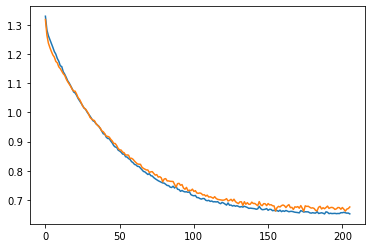

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [32]:
predictions=model.predict(val_df)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [33]:
predictions

array([[0.50181156],
       [0.59574753],
       [0.48873767],
       [0.2901342 ],
       [0.49079144],
       [0.48879614],
       [0.4966123 ],
       [0.48174945],
       [0.6564152 ],
       [0.4900754 ],
       [0.484657  ],
       [0.5132272 ],
       [0.49019033],
       [0.08777097],
       [0.4882039 ],
       [0.09002224],
       [0.5041682 ],
       [0.50157946],
       [0.5028293 ],
       [0.1398716 ],
       [0.32840866],
       [0.5357782 ],
       [0.4883312 ],
       [0.45400923],
       [0.5010257 ],
       [0.5134041 ],
       [0.504647  ],
       [0.08338353],
       [0.60114276],
       [0.4900318 ],
       [0.4813272 ],
       [0.47198933],
       [0.48596427],
       [0.48998886],
       [0.49046272],
       [0.04522258],
       [0.5001864 ],
       [0.49860716],
       [0.49913272],
       [0.49701208],
       [0.03388786],
       [0.5439665 ],
       [0.4819353 ],
       [0.04238015],
       [0.5002122 ],
       [0.53367877],
       [0.48559862],
       [0.497

In [34]:
rezults=[]
class_one = predictions > 0.5
for x in class_one:
    if x==True:
        rezults.append(1)
    else:
        rezults.append(0)

In [35]:
class_one

array([[ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [

In [36]:
rezults

[1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1]

In [37]:
fbeta_score(val_label, rezults, average='binary', beta=1,labels=[0,1],pos_label=1)

0.2222222222222222

In [39]:
caly_df

array([[-0.2346794 , -0.27644221, -0.27401497, ..., -0.19443738,
        -0.13395776, -0.24327723],
       [-0.23610784, -0.28298729, -0.28281055, ..., -0.19443738,
        -0.13395776, -0.24327723],
       [-0.23522835, -0.26679298, -0.2824077 , ..., -0.19443738,
        -0.13395776, -0.24327723],
       ...,
       [-0.23574224, -0.2795616 , -0.27470636, ..., -0.10068831,
        -0.13395776, -0.1702215 ],
       [-0.23579253, -0.27581554, -0.27474406, ..., -0.15356456,
        -0.13395776, -0.23266026],
       [-0.14972453, -0.24653519, -0.22233403, ..., -0.19443738,
        -0.13395776, -0.24327723]])

In [41]:
caly_label=np.asarray(caly_label).astype(np.int)

In [49]:
kfold = StratifiedKFold(n_splits=5, shuffle=False)
cvscores = []
dane_do_zapisu=pd.DataFrame()
licznik=1

for train, test in kfold.split(caly_df, caly_label): # train 80, test 20 %
    train, val = train_test_split(train, test_size=0.1, random_state=42) # train 80 % test 10% val 10 %
    
    returny=numerai_model(caly_df[train], caly_label[train], caly_df[val],caly_label[val], p)
    
    model=returny[1]
    # evaluate the model
    
    predictions = model.predict(caly_df[test])
    rezults=[]
    class_one = predictions > 0.5
    for x in class_one:
        if x==True:
            rezults.append(1)
        else:
            rezults.append(0)

    scores = fbeta_score(caly_label[test], rezults, average='binary', beta=1,labels=[0,1],pos_label=1)
    dane_folda=pd.DataFrame({"pred": list(rezults),
                                "obs": caly_label[test].tolist(),
                                 "probability":list(predictions),
                                "Fold":licznik})
    
    dane_do_zapisu=pd.concat([dane_do_zapisu,dane_folda])
    cvscores.append(scores)
    licznik+=1

{'first_neuron': 55, 'hidden_neuron': 50, 'hidden_layers': 0, 'epochs': 100000, 'last_activation': 'sigmoid', 'batch_size': 64, 'lr': 0.001, 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.01, 'bias_regularizer': 0.001, 'activity_regularizer': 0.001, 'dropout': 0.1, 'kernel_initializer': 'identity', 'activation_layer': 'tanh', 'batc_normalization': False}
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restorin

Restoring model weights from the end of the best epoch: 192.
Epoch 00242: early stopping
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [53]:
len(caly_df)

710

In [54]:
len(train)

511

In [55]:
len(test)

142

In [56]:
len(val)

57

Text(0.5, 0, 'Epoka')

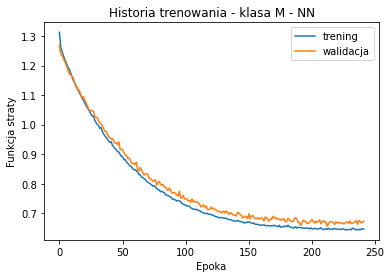

In [90]:
history,model=returny
plt.plot(history.history['loss'], label="trening")
plt.plot(history.history['val_loss'], label="walidacja")
plt.title('Historia trenowania - klasa M - NN')
plt.legend(loc="upper right")
plt.ylabel('Funkcja straty')
plt.xlabel('Epoka')

In [58]:
cvscores

[0.2857142857142857,
 0.27692307692307694,
 0.1764705882352941,
 0.2809917355371901,
 0.3076923076923077]

In [60]:
sum(cvscores)/len(cvscores) 

0.2655583988204309

In [45]:
sum(cvscores)/len(cvscores) #

0.2802964592260091

In [61]:
dane_do_zapisu.to_csv('D:\\STUDIA\\ROK_II\\Magisterka\\Modele\\Wszystkie_predykcje_modeli\\M_normal_neural_network.csv')

In [62]:
dane_do_zapisu

,pred,obs,probability,Fold
0,1,0,[0.5146463],1
1,1,0,[0.51871866],1
2,1,0,[0.51572174],1
3,0,0,[0.46442667],1
4,0,0,[0.121781945],1
...,...,...,...,...
137,1,1,[0.5005747],5
138,1,1,[0.5022003],5
139,1,1,[0.5035894],5
140,0,1,[0.4963241],5


In [63]:
prawdopodob_0=dane_do_zapisu[dane_do_zapisu['obs']==0]['probability']
prawdopodob_1=dane_do_zapisu[dane_do_zapisu['obs']==1]['probability']

In [64]:
prawdopodob_0

0        [0.5146463]
1       [0.51871866]
2       [0.51572174]
3       [0.46442667]
4      [0.121781945]
           ...      
115     [0.50222397]
116      [0.5006426]
117      [0.5006905]
118     [0.50103205]
119     [0.50254786]
Name: probability, Length: 602, dtype: object

In [65]:
test_0=0
for x in list(prawdopodob_0):
    test_0+=float(x)
print(test_0/len(prawdopodob_0))

0.4477612900971574


In [66]:
prawdopodob_1

121     [0.5173317]
122    [0.51868147]
123    [0.51758903]
124      [0.517444]
125     [0.5137713]
           ...     
137     [0.5005747]
138     [0.5022003]
139     [0.5035894]
140     [0.4963241]
141    [0.49579507]
Name: probability, Length: 108, dtype: object

In [67]:
test_1=0
for x in list(prawdopodob_1):
    test_1+=float(x)
print(test_1/len(prawdopodob_1))

0.48268709552508815


In [68]:
pred=[]
for x in list(dane_do_zapisu['pred']):
    if x==0:
        pred.append('M0')
    else:
        pred.append('M1')

In [69]:
dane_do_zapisu[dane_do_zapisu['Fold']==5]

,pred,obs,probability,Fold
0,0,0,[0.15837845],5
1,0,0,[0.010624051],5
2,1,0,[0.5023293],5
3,0,0,[0.49559027],5
4,0,0,[0.06160125],5
...,...,...,...,...
137,1,1,[0.5005747],5
138,1,1,[0.5022003],5
139,1,1,[0.5035894],5
140,0,1,[0.4963241],5


In [70]:
pred

['M1',
 'M1',
 'M1',
 'M0',
 'M0',
 'M1',
 'M1',
 'M1',
 'M1',
 'M0',
 'M1',
 'M1',
 'M1',
 'M0',
 'M1',
 'M0',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M0',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M0',
 'M0',
 'M1',
 'M1',
 'M0',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M0',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M0',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M0',
 'M1',
 'M1',
 'M0',
 'M1',
 'M1',
 'M1',
 'M1',
 'M0',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M0',
 'M1',
 'M1',
 'M1',
 'M1',
 'M0',
 'M1',
 'M0',
 'M0',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M0',
 'M0',
 'M1',
 'M0',
 'M1',
 'M0',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',
 'M0',
 'M1',
 'M1',
 'M1',
 'M1',
 'M1',

In [71]:
obs=[]
for x in list(dane_do_zapisu['obs']):
    if x==0:
        obs.append('M0')
    else:
        obs.append('M1')

In [72]:
from sklearn.metrics import confusion_matrix

In [73]:
cf_matrix = confusion_matrix(y_true=obs,y_pred=pred )

In [74]:
cf_matrix

array([[255, 347],
       [ 34,  74]], dtype=int64)

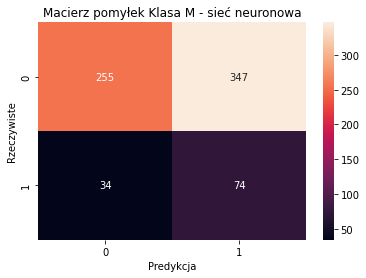

In [75]:

ax = plt.axes()
sns.heatmap(cf_matrix, annot=True, fmt='g')

ax.set_title('Macierz pomyłek Klasa M - sieć neuronowa')
plt.ylabel('Rzeczywiste')
plt.xlabel('Predykcja')
plt.show()


In [79]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

precision = precision_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'], labels=[0,1], average='binary',pos_label=1)
recall = recall_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'], labels=[0,1], average='binary',pos_label=1)
f1score=fbeta_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'], labels=[0,1], average='binary',pos_label=1, beta=1)
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('F1score: %.3f' % f1score)

Recall: 0.685
Precision: 0.176
F1score: 0.280


In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve

In [95]:
from sklearn.metrics import roc_curve

Text(0.5, 1.0, 'Precision-Recall Curve')

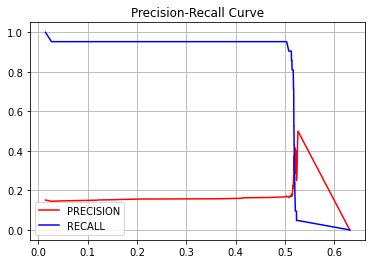

In [102]:

# Plot Precision-Recall curve using sklearn.
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(dane_do_zapisu[dane_do_zapisu['Fold']==1]['obs'],
                                             dane_do_zapisu[dane_do_zapisu['Fold']==1]['probability'],
                                             pos_label=1)
  
# Plot the output.
plt.plot(threshold, precision[:-1], c ='r', label ='PRECISION')
plt.plot(threshold, recall[:-1], c ='b', label ='RECALL')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve')